In [38]:
import time
import numpy as np
import pandas as pd
import math
import tqdm
import tqdm.notebook as tqdm_nb
import tqdm.auto as tqdm_a
from termcolor import colored
from functools import partial
from IPython.display import display

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score
                            )
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.cluster import SpectralClustering
from sklearn.inspection import permutation_importance

import scipy.stats as sps
from catboost import CatBoostClassifier, CatBoostRegressor

In [2]:
data_1 = pd.read_excel('./1400.xlsx', sheet_name=1)

In [4]:
data = pd.read_excel('./1400.xlsx', sheet_name=0)

In [7]:
data = pd.concat([data, data_1], axis=1)

In [10]:
df = data.copy()

In [44]:
ignore_features = ['Title', 'IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'SMILES', 'Pictures',
                  'molecule']

In [30]:
nan_percentage = df.isna().mean()
cols_to_drop = nan_percentage[nan_percentage > 0.95].index
df_cleaned = df.drop(columns=cols_to_drop)

In [31]:
df_cleaned.shape

(1468, 65)

In [34]:
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        # print(col)
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            # columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col].values) >= corr_threshold]
            if len(columns_to_check) > 1:
                print(f'{col} -> {columns_to_check}')
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()
                        
                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1
                            
                for bad_col in bad_cols:
                    dropped[bad_col] += 1
                
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [35]:
corr_mx = df_cleaned.drop(columns=ignore_features).corr()
corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.9)

C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_5040\844396069.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mx = df_cleaned.drop(columns=ignore_features).corr()
Get correlated features: 100%|███████████████████████████████████████████████████████| 53/53 [00:00<00:00, 2036.95it/s]

Molecular weight -> ['Molecular weight' 'mol_MW' 'SASA' 'volume' 'QPpolrz' 'QPlogPC16'
 'QPlogPoct' '#nonHatm']
Polar SA -> ['Polar SA' 'QPlogPw']
FISA -> ['FISA' 'QPlogBB']
donorHB -> ['donorHB' 'ACxDN^.5/SA']
accptHB -> ['accptHB' 'QPlogPw']
QPlogPo/w -> ['QPlogPo/w' 'QPlogKhsa']
QPlogS -> ['QPlogS' 'CIQPlogS']
PSA -> ['PSA' '#NandO']
#ringatoms -> ['#ringatoms' '#in56']


In [36]:
df_no_corr = df_cleaned.drop(columns=corr_feats)
df_no_corr.shape

(1468, 51)

In [51]:
y = df_no_corr['IC50, mmg/ml'].iloc[:, 0:1]
X = df_no_corr.drop(columns=ignore_features) 
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)

In [54]:
import catboost
from catboost import CatBoostRegressor, Pool

# Define the training and validation datasets using CatBoost's Pool format
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_validation, y_validation)

# Define the CatBoostRegressor model
model = CatBoostRegressor(
    iterations=1000,  # This is a large number; early stopping will halt the process beforehand if the conditions are met
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    eval_metric='R2',
    early_stopping_rounds=50  # Stops training after 50 rounds if there's no improvement on the validation set
)

# Train the model
model.fit(
    train_pool,
    eval_set=val_pool, 
    verbose=50,  # Print out metric values on training and validation datasets every 50 iterations
    use_best_model=True  # Use the best model (with the smallest validation score) for predictions
)

# After training, you can use the model to predict on new data
# predictions = model.predict(new_data)


0:	learn: 0.0522969	test: 0.0379854	best: 0.0379854 (0)	total: 5.98ms	remaining: 5.97s
50:	learn: 0.5457162	test: 0.2139171	best: 0.2142129 (30)	total: 193ms	remaining: 3.58s
100:	learn: 0.6957080	test: 0.2064516	best: 0.2190634 (78)	total: 366ms	remaining: 3.25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2190633838
bestIteration = 78

Shrink model to first 79 iterations.


In [56]:
def build_cb_regressor(X_train, y_train, X_valid, y_valid, params=None, cat_features=[], 
                       verbose=50, seed=15, n_jobs=-1, fit_kwargs=None):

    # Default parameters setup
    params = {} if params is None else params.copy()
    params['verbose'] = params.get('verbose') or verbose
    params['random_state'] = params.get('random_state') or seed
    params['thread_count'] = params.get('thread_count') or n_jobs
    
    # Default fitting parameters setup
    fit_kwargs =  {} if fit_kwargs is None else fit_kwargs.copy()

    # Create and train the regressor model
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        cat_features = cat_features,
        **fit_kwargs
    )

    return model

In [57]:
def get_feature_importance(model):
    imp = pd.Series(model.feature_importances_,
                   index=model.feature_names_)\
                         .sort_values(ascending=False)\
                         .to_frame()\
                         .reset_index()\
                         .rename(columns={'index': 'feat_name', 0: 'feat_imp'})
    return imp

def plot_feature_importance(model, top_n=None, figsize=None):
    imp = get_feature_importance(model)
    
    fig, ax = plt.subplots(figsize=figsize or (12, 6))
    imp.set_index('feat_name')\
            .sort_values(by='feat_imp')\
            .tail(top_n or len(imp))\
            .plot(kind='barh', color='lightblue', ec='black', ax=ax, width=0.5)
    
    t = f"(Top: {top_n})" if top_n is not None else ""
    ax.set_title("Feature importance " + t)
    ax.grid(False, axis='y')
    
    return fig

def get_permutation_feature_importance(clf, X_test, y_test, scorer, n_repeats=10, seed=15, n_jobs=8, perm_kwargs=None):
    perm_kwargs = {}  if perm_kwargs is None else perm_kwargs.copy()
    perm_kwargs['n_repeats'] = perm_kwargs.get('n_repeats') or n_repeats
    perm_kwargs['random_state'] = perm_kwargs.get('random_state') or seed
    perm_kwargs['n_jobs'] = perm_kwargs.get('n_jobs') or n_jobs
    
    perm_result = permutation_importance(clf, X_test, y_test, scoring=scorer, **perm_kwargs)
    
    perm_imp_df = pd.DataFrame({'feat_name' : clf.feature_names_,
                                'feat_imp' : perm_result['importances_mean'],
                                'feat_imp_std' : perm_result['importances_std']})
    perm_imp_df = perm_imp_df.sort_values(by='feat_imp', ascending=False)\
                                .reset_index(drop=True)
    
    return perm_imp_df


def feat_selection_by_permutation(train_df, test_df, y_train, y_test, lst_feats=None, model_name=None, 
                                 model_params=None, scorer=None, perm_kwargs=None, add_noise_feats=True,
                                 seed=15, n_jobs=-1, fit_kwargs=None):
    model_params = {} if model_params is None else model_params.copy()
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs.copy()
    perm_kwargs = {} if perm_kwargs is None else perm_kwargs.copy()
    
    lst_feats = train_df.columns.to_list() if lst_feats is None else lst_feats.copy()
    lst_cat_feats = [c for c in train_df.select_dtypes(include=['O', 'category']).columns if c in lst_feats]
    
    n_feats = len(lst_feats)
    train_df = train_df.copy()
    tets_df = test_df.copy()
    
    if add_noise_feats:
        train_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        train_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        
        test_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        test_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        lst_feats += ['NORMAL', 'UNIFORM']
        
    print(f">> Building model: {model_name}")
    start_t = time.time()
    
    if model_name == 'catboost':
        clf = build_cb_model(train_df[lst_feats], y_train, test_df[lst_feats], y_test,
                            cat_features=lst_cat_feats,
                            params=model_params,
                            verbose=0, seed=seed, n_jobs=-1, fit_kwargs=fit_kwargs)
    else:
        raise ValueError('incorrect model name')
        
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    
    print(f"Start permutation", "with adding noise feats" if add_noise_feats else "", "...")
    
    perm_imp_df = get_permutation_feature_importance(clf, test_df[lst_feats], y_test, scorer, seed=seed, **perm_kwargs)
    
    if add_noise_feats:
        uniform_perm_value = perm_imp_df[perm_imp_df.feat_name == 'UNIFORM']['feat_imp'].values[0]
        normal_perm_value = perm_imp_df[perm_imp_df.feat_name == 'NORMAL']['feat_imp'].values[0]
        perm_filter = (perm_imp_df.feat_imp <= max(0, normal_perm_value, uniform_perm_value))
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        train_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
        test_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
    else:
        perm_filter = (perm_imp_df.feat_imp <= 0)
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        
    perm_imp_df = perm_imp_df.reset_index(drop=True)
    lst_sel_feats = perm_imp_df['feat_name'].to_list()
    
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    print(f"Reduced number of feats: {n_feats} -> {len(lst_sel_feats)}")
    
    return perm_imp_df, lst_sel_feats

def custom_forward_selection(X_train, y_train, X_test, y_test, task_type='binary', eval_sets=None, eval_names=None,
                            lst_feats_for_select=None, cat_features=None, scorer=None, maximize_score=None, maximize_eval_name='Test',
                            metric_thres=1e-5, step=1, method='fast', reorder_init=False, model_name='catboost', model_params=None,
                             seed=15, n_jobs=-1, perm_kwargs=None, fit_kwargs=None):
    
    init_features = X_train.columns.to_list() if lst_feats_for_select is None else lst_feats_for_select
    cat_features = [] if cat_features is None else cat_features
    init_cat_features = [c for c in cat_features if c in set(init_features)]
    
    eval_sets = [(X_train, y_train), (X_test, y_test)] if eval_sets is None else eval_sets
    eval_names = ['Train', 'Test'] if eval_names is None else eval_names
    
    num_fs_steps = len(init_features)
    sign_coef = 1 if maximize_score else -1
    bad_fs_feats = []
    stop_selection_flag = False
    start_i = 0
    sel_features = []
    
    scores = {name : [] for name in eval_names}
    history = dict()
    history['metrics'] = list()
    history['scores'] = list()
    history['num_feats'] = list()
    history['sel_feats'] = list()
    history['iteration'] = list()
    
    progress = tqdm.tqdm(desc='fs_step')
    while not stop_selection_flag:
        excluded_feat = None
        
        n = len(init_features)
        n_iteration = (n + step - 1) // step
        
        for i in range(start_i, n_iteration):
            from_feat_idx = i * step
            to_feat_idx = (i + 1) * step
            feats = init_features[from_feat_idx: to_feat_idx]
            
            sel_features.extend(feats)
            print(sel_features)
            sel_cat_features = [c for c in init_cat_features if c in sel_features]
            
            print(f'--- Iteration: {i}. Number of feats: {to_feat_idx}/{n} ---')
            print(f'>> Building model: {model_name}')
            start_t = time.time()
            
            clf = build_cb_model(X_train[sel_features], y_train, 
                                     X_test[sel_features], y_test,
                                     cat_features=sel_cat_features, params=model_params,
                                     verbose=0, seed=seed, n_jobs=n_jobs, fit_kwargs=None)
            
            target_proba_sets = predict_proba_4eval_sets(clf, eval_sets)
            metrics_df = get_metrics_clf(target_proba_sets, eval_names=eval_names)
            display(metrics_df)
            
            for eval_samp, eval_name in zip(eval_sets, eval_names):
                score = scorer(clf, eval_samp[0][clf.feature_names_], eval_samp[1])
                scores[eval_name].append(score)
                
            end_t = time.time()
            print(f'>> Done ({end_t  - start_t:.2f}s)')
            
            if i > start_i:
                prev_valid = scores[maximize_eval_name][-2]
                curr_valid = scores[maximize_eval_name][-1]
                d_valid = sign_coef * (curr_valid - prev_valid)
                
                if (d_valid <= metric_thres):
                    print('>> Excluded:', feats)
                    print(*[f'>> score increase_{name}: {sign_coef*np.diff(scores[name][-2:])[0]:.3f}' for name in eval_names], sep='\n')
                    
                    new_init_features = [c for c in init_features if c not in set(feats)]
                    new_init_cat_features = [c for c in cat_features if c in set(new_init_features)]
                    
                    if reorder_init:
                        clf = build_cb_model(X_train[new_init_features], y_train,
                                                 X_test[new_init_features], y_test,
                                                 cat_features=new_init_cat_features, params=model_params,
                                                 verbose=0, seed=seed,  n_jobs=n_jobs, fit_kwargs=None)
                        start_t = time.time()
                        print(f'>> Start sorted features after excluding. Method: {method}')
                        if method == 'fast':
                            new_init_sorted_features = get_feature_importance(clf)['feat_name'].to_list()
                        elif method == 'permutation':
                            new_init_sorted_features = get_permutation_feature_importance(clf, X_test[new_init_features],
                                                                                          y_test, scorer)['feat_name'].to_list()
                            
                    init_features = new_init_sorted_features.copy() if reorder_init else new_init_features.copy()
                    init_cat_features = [c for c in cat_features if c in set(init_features)]
                    
                    excluded_feat = feats
                    bad_fs_feats.extend(excluded_feat)
                    
                    end_t = time.time()
                    print(f'>> Done ({end_t - start_t:.2f}s)')
                    break
                    
            history['metrics'].append(metrics_df)
            history['scores'].append(scores)
            history['num_feats'].append(len(sel_features))
            history['sel_feats'].append(sel_features.copy())
            history['iteration'].append(i)
                                        
        if excluded_feat is None:
            stop_selection_flag = True
        else:
            if reorder_init:
                start_i = 0
                sel_features = []
                scores = {name: [] for name in eval_names}
                history = dict()
                history['metrics'] = list()
                history['scores'] = list()
                history['num_feats'] = list()
                history['sel_feats'] = list()
                history['iteration'] = list()                     
            else:
                start_i = from_feat_idx
                sel_features = init_features[:start_i]                       

        progress.update()
        print('*'*50)
    print(f'>> Finish. Number of features in final subset: {len(sel_features)}')

    return(history)

In [58]:
imp = get_feature_importance(model)

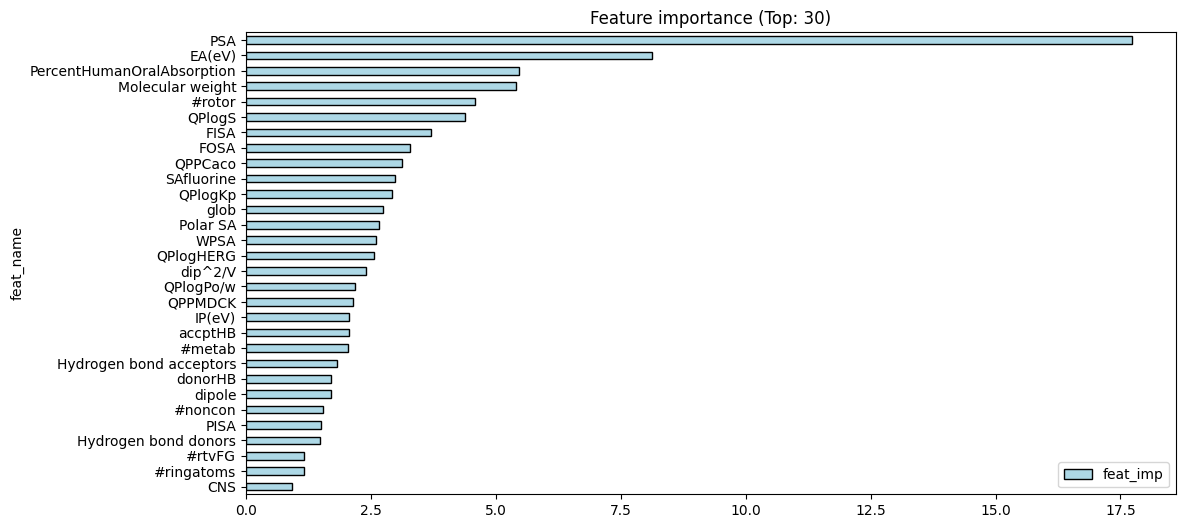

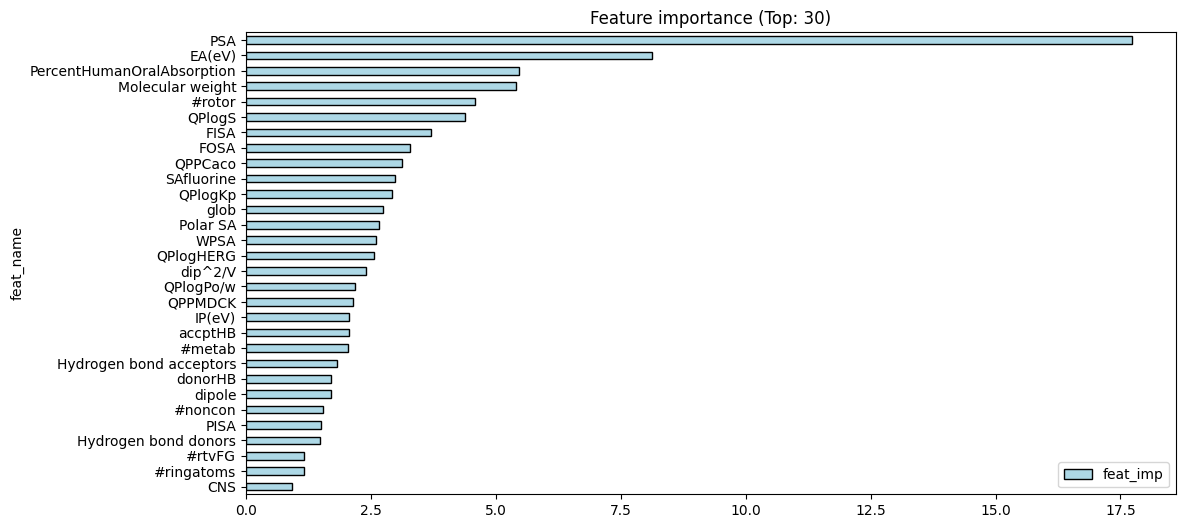

In [60]:
zero_imp = imp[imp.feat_imp == 0.0].feat_name.values
plot_feature_importance(model, top_n=30)

In [66]:
df_no_corr = df_no_corr.drop(columns=zero_imp)

In [67]:
y = df_no_corr['IC50, mmg/ml'].iloc[:, 0:1]
X = df_no_corr.drop(columns=ignore_features) 
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)

In [76]:
X_train

,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,#stars,#amine,#amidine,#acid,#amide,#rotor,...,#metab,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,RuleOfFive,#ringatoms,#in34,#noncon
912,549.597,8,1,135.17,2.0,1.0,0.0,0.0,0.0,5.0,...,5.0,2.0,0.0,0.000,149.692,12.000,0.0,33.0,0.0,5.0
691,400.413,7,4,171.21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
852,489.331,5,0,69.65,0.0,0.0,0.0,0.0,0.0,3.0,...,3.0,1.0,0.0,0.000,77.403,5.000,1.0,25.0,0.0,0.0
1000,469.882,7,4,127.53,0.0,0.0,0.0,0.0,1.0,8.0,...,8.0,2.0,0.0,26.658,150.560,8.000,1.0,22.0,0.0,3.0
1237,421.522,4,3,119.56,1.0,0.0,0.0,0.0,0.0,6.0,...,6.0,1.0,0.0,0.000,94.767,6.000,1.0,22.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,412.297,6,0,74.97,1.0,0.0,0.0,0.0,0.0,3.0,...,2.0,3.0,100.0,159.913,0.000,81.035,0.0,16.0,0.0,0.0
558,314.409,2,1,73.66,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,3.0,100.0,0.000,0.000,56.987,0.0,16.0,0.0,6.0
1369,295.426,3,0,38.77,1.0,1.0,0.0,0.0,0.0,4.0,...,3.0,3.0,0.0,0.000,48.002,4.000,0.0,13.0,0.0,11.0
1095,289.468,1,1,40.71,0.0,1.0,0.0,0.0,0.0,4.0,...,2.0,3.0,0.0,0.000,38.090,3.000,0.0,12.0,4.0,7.0


In [68]:
import catboost
from catboost import CatBoostRegressor, Pool

# Define the training and validation datasets using CatBoost's Pool format
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_validation, y_validation)

# Define the CatBoostRegressor model
model = CatBoostRegressor(
    iterations=1000,  # This is a large number; early stopping will halt the process beforehand if the conditions are met
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    eval_metric='R2',
    early_stopping_rounds=50  # Stops training after 50 rounds if there's no improvement on the validation set
)

# Train the model
model.fit(
    train_pool,
    eval_set=val_pool, 
    verbose=50,  # Print out metric values on training and validation datasets every 50 iterations
    use_best_model=True  # Use the best model (with the smallest validation score) for predictions
)

# After training, you can use the model to predict on new data
# predictions = model.predict(new_data)


0:	learn: 0.0522969	test: 0.0379854	best: 0.0379854 (0)	total: 4.84ms	remaining: 4.84s
50:	learn: 0.5457162	test: 0.2139171	best: 0.2142129 (30)	total: 210ms	remaining: 3.9s
100:	learn: 0.6957080	test: 0.2064516	best: 0.2190634 (78)	total: 382ms	remaining: 3.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2190633838
bestIteration = 78

Shrink model to first 79 iterations.


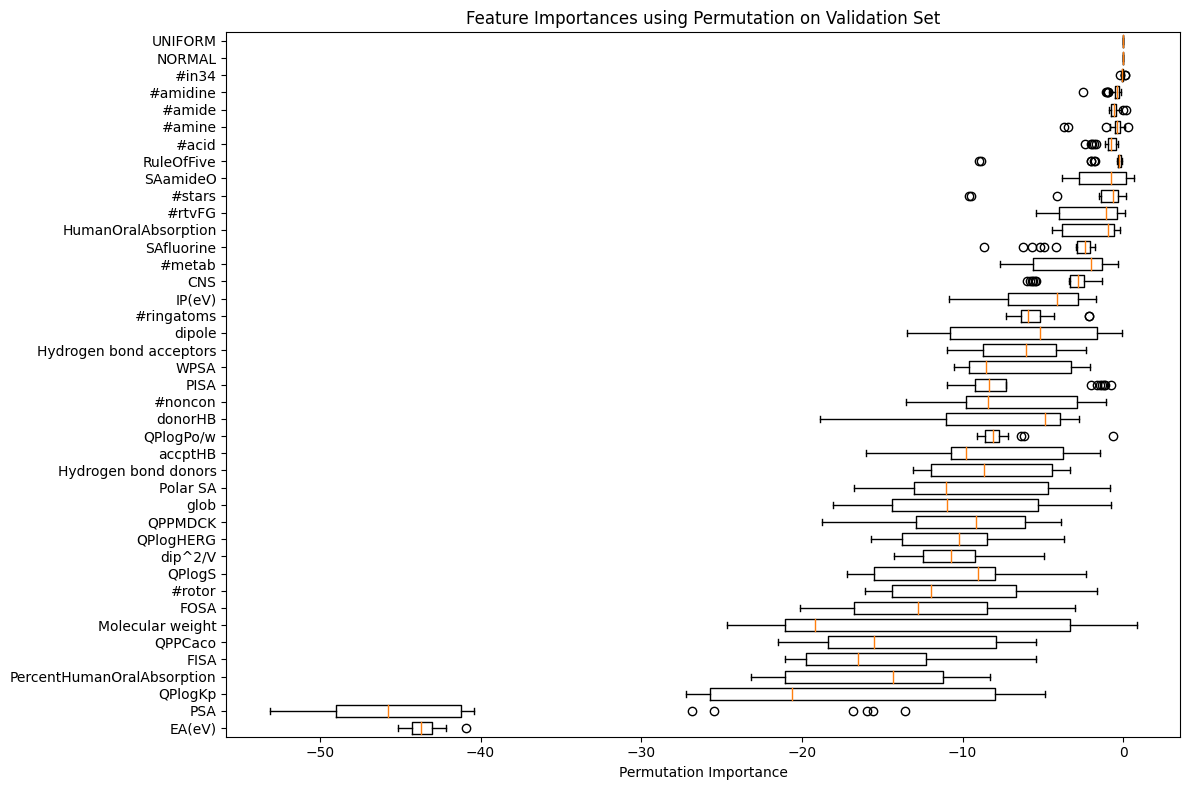

In [74]:
from sklearn.inspection import permutation_importance

def compute_permutation_importance(model, X_valid, y_valid, n_repeats=30, random_state=0):
    
    perm_importance = permutation_importance(
        model, X_valid, y_valid, n_repeats=n_repeats, 
        random_state=random_state, n_jobs=-1
    )
    
    return perm_importance

# Use the function
perm_importance = compute_permutation_importance(model, X_validation, y_validation)

# Display importance scores
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(12, 8))
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, widths=0.7)
plt.yticks(np.arange(len(X_validation.columns)) + 1, X_validation.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importances using Permutation on Validation Set')
plt.tight_layout()
plt.show()


In [75]:
import pandas as pd

# Create a DataFrame to display results
perm_importance_df = pd.DataFrame({
    'Feature': X_validation.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std,
}).sort_values(by='Importance Mean', ascending=False)

print(perm_importance_df)


                       Feature  Importance Mean  Importance Std
40                     UNIFORM         0.000000        0.000000
39                      NORMAL         0.000000        0.000000
37                       #in34        -0.059025        0.071246
6                     #amidine        -0.539699        0.448214
8                       #amide        -0.548870        0.254082
5                       #amine        -0.574445        0.841949
7                        #acid        -0.874856        0.538157
35                  RuleOfFive        -1.004623        2.196508
33                    SAamideO        -1.225751        1.482543
4                       #stars        -1.409759        2.316881
10                      #rtvFG        -1.904955        1.854419
30         HumanOralAbsorption        -2.045597        1.608237
32                  SAfluorine        -2.988493        1.585501
29                      #metab        -3.208041        2.360632
11                         CNS        -3